In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv('/ml-100k/ua.base', delimiter = '\t', names = ['userID', 'movieID', 'rating', 'timestamp'])
df.head()

,userID,movieID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [3]:
df.dtypes

userID       int64
movieID      int64
rating       int64
timestamp    int64
dtype: object

In [4]:
print(df['userID'].unique().size)
print(df['movieID'].unique().size)

943
1680


In [5]:
rating_matrix = pd.pivot_table(df, values = 'rating', index = 'userID', columns = 'movieID', fill_value = 0)
print(rating_matrix.shape)
rating_matrix.head()

(943, 1680)


movieID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userID,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df = pd.read_csv('/ml-100k/ua.test', delimiter = '\t', names = ['userID', 'movieID', 'rating', 'timestamp'])
test_df.head()

,userID,movieID,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201


In [7]:
test_df.dtypes

userID       int64
movieID      int64
rating       int64
timestamp    int64
dtype: object

In [8]:
test_df.drop(columns = 'timestamp', inplace = True)
test_df.head()

,userID,movieID,rating
0,1,20,4
1,1,33,4
2,1,61,4
3,1,117,3
4,1,155,2


In [9]:
class MatrixFactorizarion:
    def __init__ (self, M, T, alpha, beta, lf, itr):
        '''
        M     : The matrix to be facatorised
        T     : values for Testing 
        alpha : Learning Parameter
        beta  : Regularization Parameter
        lf    : Latent Features
        '''
        
        self.M = M   
        self.alpha = alpha
        self.beta = beta
        self.lf = lf
        self.itr = itr
        
        self.users, self.movies = M.shape
        
        self.test_set = T
        
    def train(self):
        #Initialize user and item matrix.
        self.P = np.random.normal(scale = 1.0/self.lf, size = (self.users, self.lf))
        self.Q = np.random.normal(scale = 1.0/self.lf, size = (self.movies, self.lf))
        
        #Initialize biases
        self.b = np.mean(self.M[np.where(self.M != 0)])
        #self.b_u = np.zeros(self.users)
        #self.b_i = np.zeros(self.movies)
        self.b_u = np.random.rand(self.users)
        self.b_i = np.random.rand(self.movies)
        
        #samples from matrix 
        self.train_set = [(i, j, self.M[i, j])
                            for i in range(self.users)
                            for j in range(self.movies)
                            if(self.M[i, j]>0)
                        ]
        
        
        training_process = []
        for i in range(self.itr):
            np.random.shuffle(self.train_set)
            self.sgd()
            e = self.rmse()
            training_process.append((i, e))
            if(i%50==49 or i == 0):
                print("Iteration %d completed. RMSE = %f" %(i+1, e))
                
        return training_process 
            
    def sgd(self):
        #Stochastic Gradient Descent
        for user, movie, rating in self.train_set:
            #user, movie, rating = self.train_set[i]
            e_ui = self.find_rating(user, movie)
            err = rating - e_ui
            
            #Updating parameters
            self.P[user, :] += self.alpha*(err*self.Q[movie, :] - self.beta*self.P[user, :])
            self.Q[movie, :] += self.alpha*(err*self.P[user, :] - self.beta*self.Q[movie, :])
            
            self.b_u[user] += self.alpha*(err - self.beta*self.b_u[user])
            self.b_i[movie] += self.alpha*(err - self.beta*self.b_i[movie])
            
    def find_rating(self, user, movie):
        #Find cuurent rating based on latent features
        r = self.b + self.b_u[user] + self.b_i[movie] + np.matmul(self.P[user,:], self.Q[movie, :].T)
        return r

    def rmse(self):
        #Root Mean Square Error for training
        error = 0
        for user, movie, rating in self.train_set:
            e_ui = self.find_rating(user, movie)
            error += (rating - e_ui)**2
        error = error/len(self.train_set)
        error = math.sqrt(error)

        return error
    
    def predict(self):
        #Final Matrix with the predicted missing values
        P = self.b + np.matmul(self.P, self.Q.T)
        for i in range(self.users):
            P[i, :] += self.b_i
        for i in range(self.movies):
            P[:, i] += self.b_u
        
        P = np.around(P).astype('int')
        
        return P
    
    def test(self):
        error = 0
        pred_M = self.predict()          #the predicted matrix, using trained parameters
        
        #print("shape = ", pred_M.shape)
        
        for user, movie, actual_rating in self.test_set:
            rating = pred_M[user-1, movie-1]          #Test file has 1-based indexing.
            error += (actual_rating - rating)**2
        error = error/len(self.test_set)
        error = math.sqrt(error)

        return error

In [10]:
M = rating_matrix.values
T = test_df.values
mf = MatrixFactorizarion(M, T, alpha = 0.01, beta = 0.15, lf = 160, itr = 250)
tr_set = mf.train()

Iteration 1 completed. RMSE = 1.015083
Iteration 50 completed. RMSE = 0.887622
Iteration 100 completed. RMSE = 0.843491
Iteration 150 completed. RMSE = 0.818122
Iteration 200 completed. RMSE = 0.806291
Iteration 250 completed. RMSE = 0.800718


In [11]:
print("Training Error = ", mf.rmse())
print("Testing Error = ", mf.test())

Training Error =  0.8007178910059651
Testing Error =  0.9762829066883403


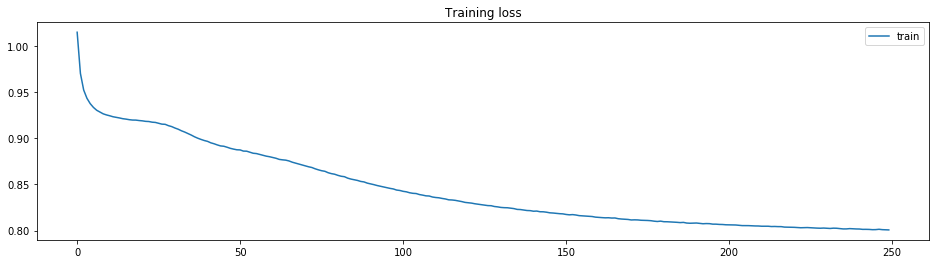

In [12]:
x = [i for i, j in tr_set]
y = [j for i, j in tr_set]

plt.figure(figsize=((16,4)))
plt.plot(x, y, label = 'train')
plt.title('Training loss')

plt.legend()
plt.show()